In [6]:
import torch
from math import exp
from random import random
from abc import ABC, abstractmethod

from copy import copy, deepcopy

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from numpy.polynomial.polynomial import Polynomial

from torch.distributions.normal import Normal
from torch.distributions.exponential import Exponential

In [7]:
class Proposal(ABC):
    symmetric = False
    def sample(self, prev=None):
        pass

    def log_prob(self, x, prev=None):
        pass

In [130]:
class MetropolisHastings:
    """
    Metropolis Hastings algorithm for sampling from a distribution p

    Attributes
    ----------
    p : distribution to sample from
    q : proposal distribution
    prev : previous sample
    """
    def __init__(self, p, q : Proposal):
        self.p = p
        self.q = q
        self.prev = None
        self.samples = []
    
    def _acceptance_prob(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x)
        if not isinstance(self.prev, torch.Tensor):
            self.prev = torch.tensor(self.prev)

        try:
            if not self.q.symmetric:
                a = self.p.log_prob(x) + self.q.log_prob(self.prev, x) - self.p.log_prob(self.prev) - self.q.log_prob(x, self.prev)
            else:
                a = self.p.log_prob(x) - self.p.log_prob(self.prev)
        except ValueError:
            return 0
        a = min(1, exp(a))
        return a        

    def _step(self):
        # Sample from q
        x = self.q.sample(self.prev)
        
        # Compute acceptance probability
        a = self._acceptance_prob(x)
        if a >= 1 or random() < a:
            self.prev = x

    def sample(self, n, x0, burnin=0):
        self.prev = x0
        for i in range(burnin):
            self._step()

        for i in range(n):
            self._step()
            self.samples.append(self.prev)
        return self.samples

    def _trace_plot(self, ax, **kwargs):
        ax.plot(self.samples)
        ax.set_title("Trace plot")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Sample value")
        return ax
    
    def _autocorrelation_plot(self, ax, **kwargs):
        ax.acorr(self.samples)
        ax.set_title("Autocorrelation plot")
        ax.set_xlabel("Lag")
        ax.set_ylabel("Autocorrelation")
        return ax
    
    def _wassterstein_distances(self, window_width = 100, **kwargs):
        w_dists = []
        target_samples = self.p.sample([len(self.samples)])

        for i in range(0 , len(self.samples) - window_width + 1, window_width):
            w_dists.append(wasserstein_distance(self.samples[i:i+window_width], target_samples[i:i+window_width]))
        return w_dists

    def _wasserstein_distance_plot(self, ax, window_width = 100, **kwargs):
        w_dists = self._wassterstein_distances(window_width, **kwargs)
        
        x_arr = np.arange(window_width - 1, len(self.samples), window_width)
        ax.plot(x_arr, w_dists, label="Wasserstein distance")

        # quadratic fit
        
        with np.printoptions(precision=2, suppress=True, formatter={'float_kind':'{:0.2f}'.format}):
            poly = Polynomial.fit(x_arr, w_dists, 1)
            ax.plot(x_arr, poly(x_arr), label=f"Linear fit: {poly.__str__()}")
            ax.set_title("Wasserstein distance plot")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Wasserstein distance")
            ax.legend()
        return ax
    
    def plot(self, **kwargs):
        fig, axs = plt.subplots(2, 2, figsize=(15, 5))
        plot_funcs = [self._trace_plot, self._autocorrelation_plot, self._wasserstein_distance_plot]

        for ax, plot_func in zip(axs.flatten(), plot_funcs):
            plot_func(ax, **kwargs)
        
        plt.tight_layout()
        return axs

In [131]:
class Mixture:
    def __init__(self, p1, p2, p1_weight=0.5):
        self.p1 = p1
        self.p2 = p2
        self.p1_weight = p1_weight

    def sample(self, arg):
        if random() < self.p1_weight:
            return self.p1.sample(arg)
        else:
            return self.p2.sample(arg)

    def log_prob(self, x, prev=None):
        return np.log(self.p1_weight * np.exp(self.p1.log_prob(x)) + (1 - self.p1_weight) * np.exp(self.p2.log_prob(x))) 

In [132]:
class IndependentGaussianProposal(Proposal):
    def __init__(self, mu, sigma):
        self.normal = Normal(mu, sigma)

    def log_prob(self, x, param=None):
        return self.normal.log_prob(x)
    
    def sample(self, prev=None):
        return self.normal.sample()

In [133]:
class RandomWalkGaussianProposal(Proposal):
    def __init__(self, sigma):
        self.normal = Normal(0, sigma)
        self.symmetric = True

    def log_prob(self, x, prev):
        return self.normal.log_prob(x - prev)
    
    def sample(self, prev):
        return prev + self.normal.sample()

In [243]:
class AggregatePlotter:
    def sample(self, samples, repetitions, obj, **kwargs):
        self.store = []
        for i in range(repetitions):
            temp_obj = deepcopy(obj)
            temp_obj.sample(samples, **kwargs)
            self.store.append(temp_obj._wassterstein_distances(50, **kwargs))
        self.store = np.array(self.store)
    
    def plot(self):
        mean_w_dists = np.mean(self.store, axis=0)
        plt.plot(mean_w_dists)

In [217]:
MH = MetropolisHastings(Normal(0, 1), RandomWalkGaussianProposal(2))
MH.sample(300, torch.tensor(8));

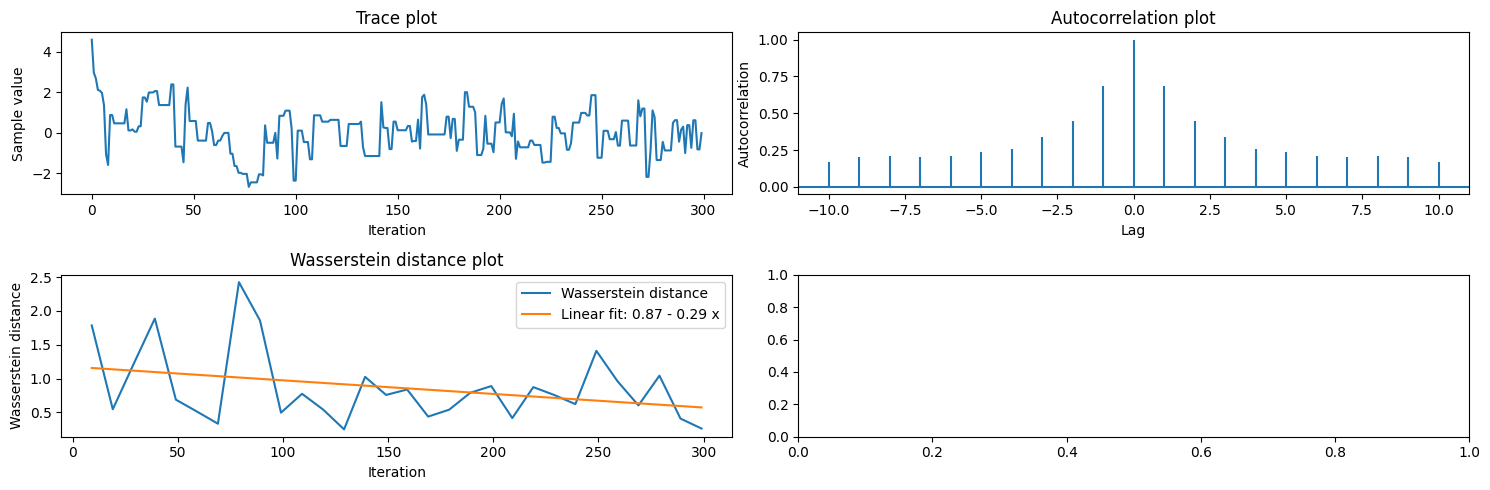

In [218]:
MH.plot(window_width=10);

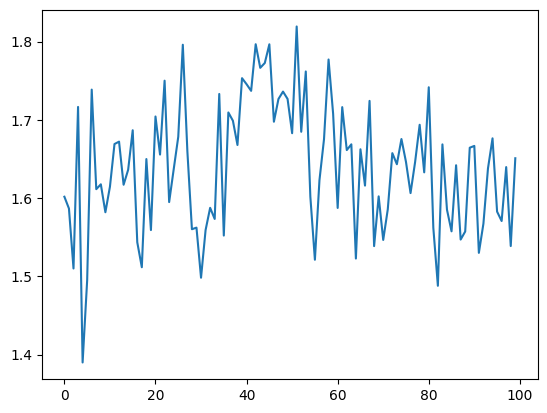

In [244]:
ag = AggregatePlotter()
ag.sample(5000, 100, MetropolisHastings(Mixture(Normal(0, 1), Normal(3, 1)), IndependentGaussianProposal(1, 1)), x0=1)
ag.plot()

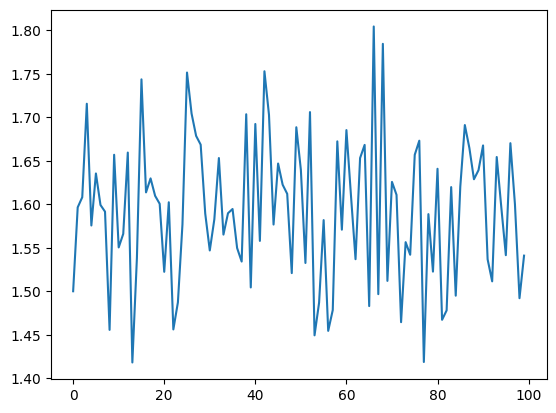

In [245]:
ag = AggregatePlotter()
ag.sample(5000, 100, MetropolisHastings(Mixture(Normal(0, 1), Normal(3, 1)), RandomWalkGaussianProposal(1)), x0=1)
ag.plot()

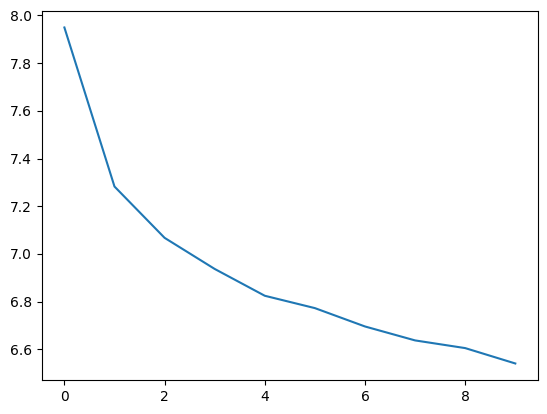

In [212]:
ag = AggregatePlotter()
ag.sample(100, 600, MetropolisHastings(Normal(10, 1), IndependentGaussianProposal(1, 1)), x0=1)
ag.plot()

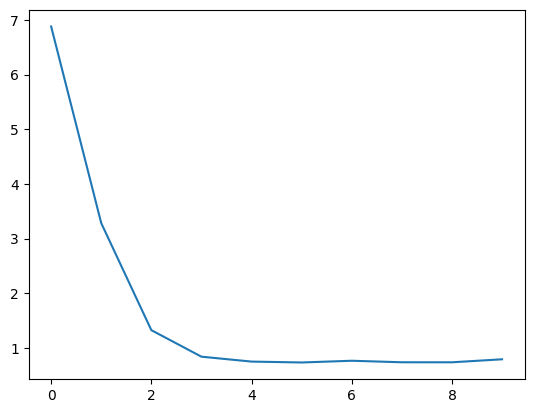

In [210]:
ag = AggregatePlotter()
ag.sample(100, 600, MetropolisHastings(Normal(10, 1), RandomWalkGaussianProposal(1)), x0=1)
ag.plot()

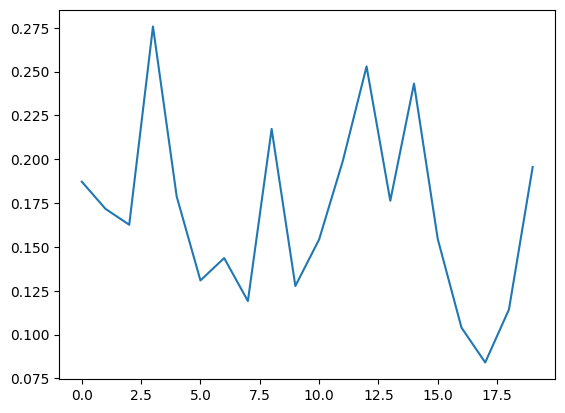

In [157]:
ag = AggregatePlotter()
ag.sample(10000, 1, MetropolisHastings(Exponential(1), RandomWalkGaussianProposal(1)), x0=1)
ag.plot()

In [136]:
MH = MetropolisHastings(Normal(0, 1), RandomWalkGaussianProposal(np.sqrt(1.25)))
MH.sample(1800, torch.tensor(1));

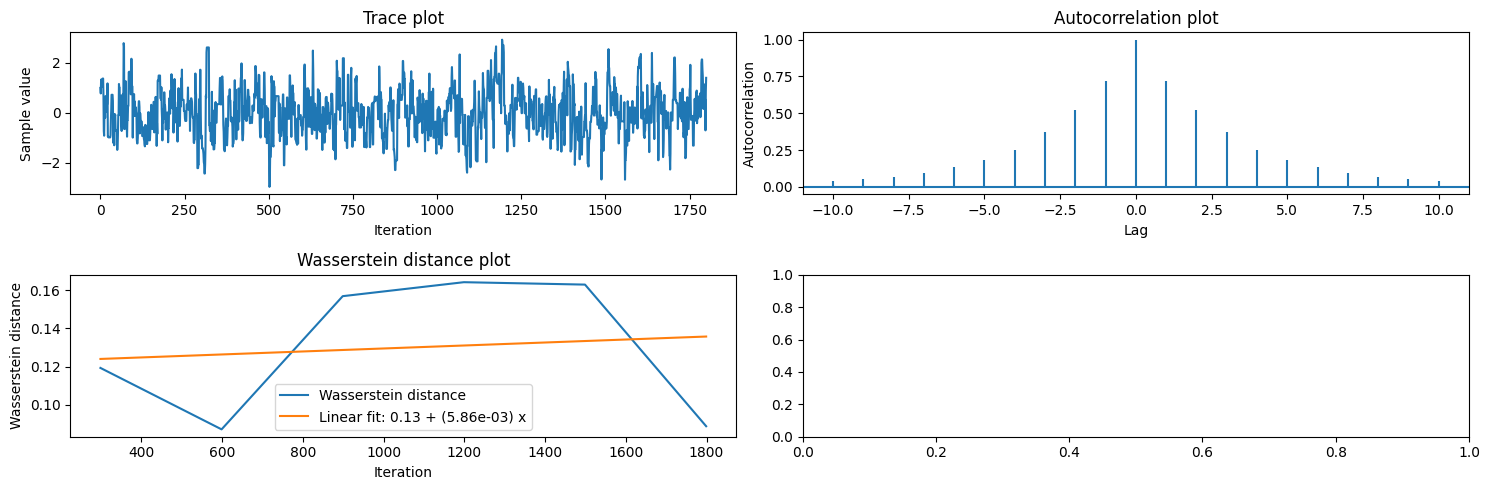

In [137]:
MH.plot(window_width=300);

In [138]:
MH = MetropolisHastings(Exponential(1), RandomWalkGaussianProposal(2))
MH.sample(3000, torch.tensor(2));

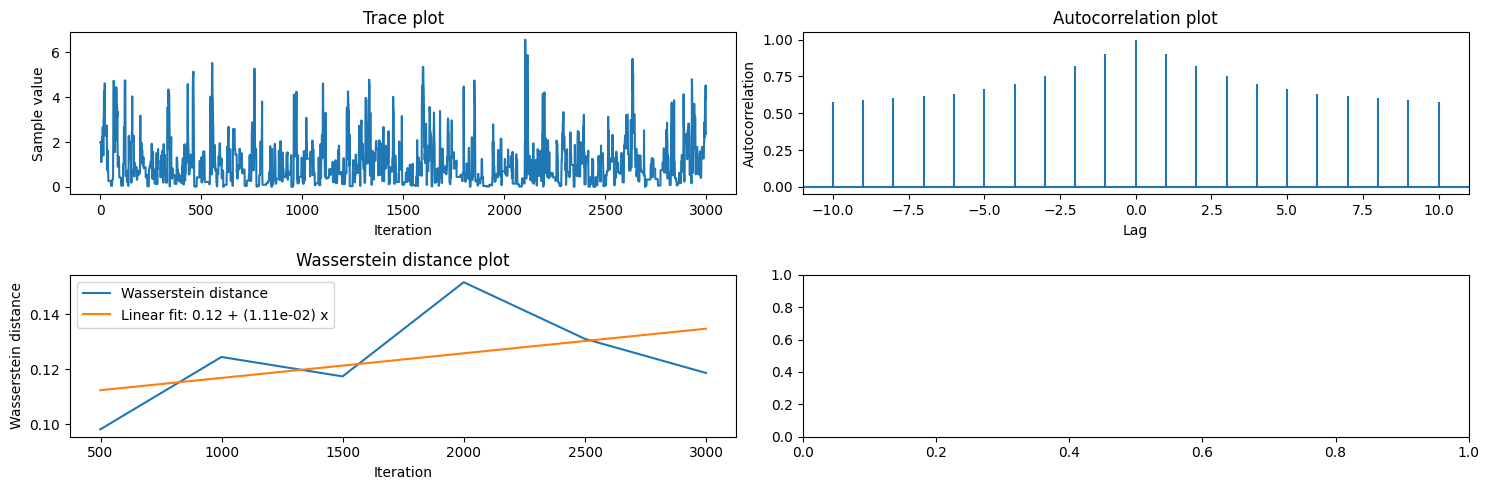

In [139]:
MH.plot(window_width=500);

In [14]:
MH = MetropolisHastings(Normal(0, 1), RandomWalkGaussianProposal(2))
MH.sample(3000, torch.tensor(20), burnin=1000);

In [15]:
MH.samples

[tensor(0.0759),
 tensor(0.0759),
 tensor(0.0759),
 tensor(-0.1339),
 tensor(0.2777),
 tensor(0.2777),
 tensor(0.2777),
 tensor(0.2777),
 tensor(0.2777),
 tensor(0.2777),
 tensor(0.3220),
 tensor(-0.0720),
 tensor(-0.0720),
 tensor(-0.0720),
 tensor(-0.0720),
 tensor(1.6739),
 tensor(0.6811),
 tensor(-0.3672),
 tensor(-0.3672),
 tensor(-0.3672),
 tensor(-0.3672),
 tensor(-0.3672),
 tensor(-0.3672),
 tensor(-0.5367),
 tensor(0.7279),
 tensor(0.7279),
 tensor(0.7279),
 tensor(0.7279),
 tensor(0.7279),
 tensor(0.7279),
 tensor(0.7279),
 tensor(0.3185),
 tensor(0.3185),
 tensor(0.3185),
 tensor(0.3185),
 tensor(0.3185),
 tensor(0.3276),
 tensor(0.9182),
 tensor(0.9182),
 tensor(-0.9181),
 tensor(-0.4609),
 tensor(-0.4609),
 tensor(-0.4609),
 tensor(-0.4609),
 tensor(-0.5338),
 tensor(0.4540),
 tensor(0.4540),
 tensor(0.4889),
 tensor(0.4889),
 tensor(0.4889),
 tensor(0.4889),
 tensor(0.0185),
 tensor(0.3596),
 tensor(0.3596),
 tensor(0.3596),
 tensor(-1.0301),
 tensor(0.8219),
 tensor(1.31

tensor([1.0419, 0.3247, 0.4410,  ..., 0.6114, 0.7438, 0.4167])
[0.16 -0.00]


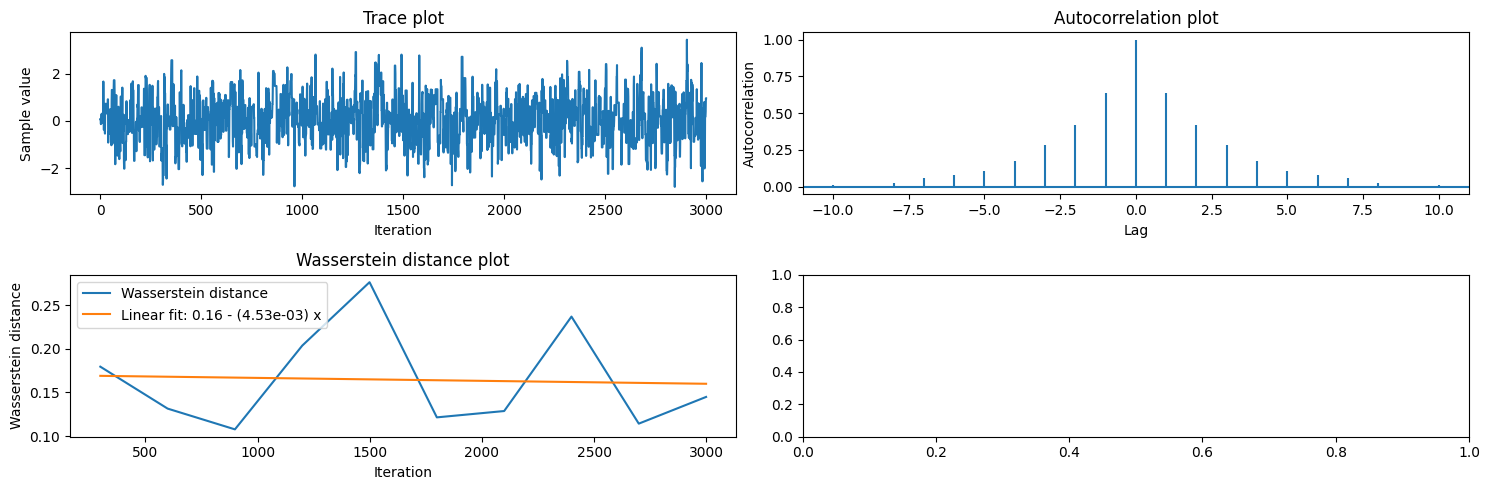

In [16]:
MH.plot(window_width=300);

In [106]:
MH2 = MetropolisHastings(Normal(0, 1), IndependentGaussianProposal(0, 0.75))
MH2.sample(30000, torch.tensor(0));

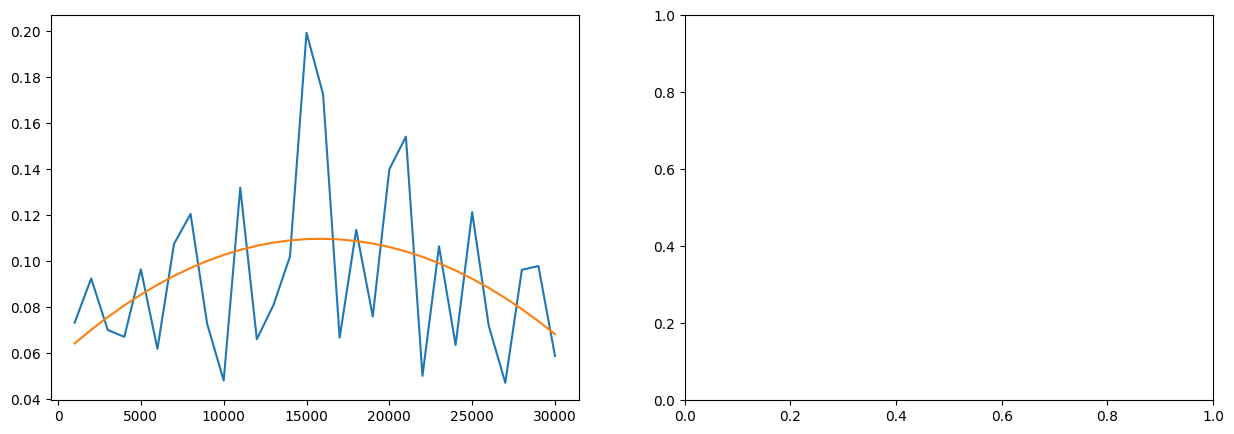

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MH2._wasserstein_distance_plot(axs[0], window_width=1000)

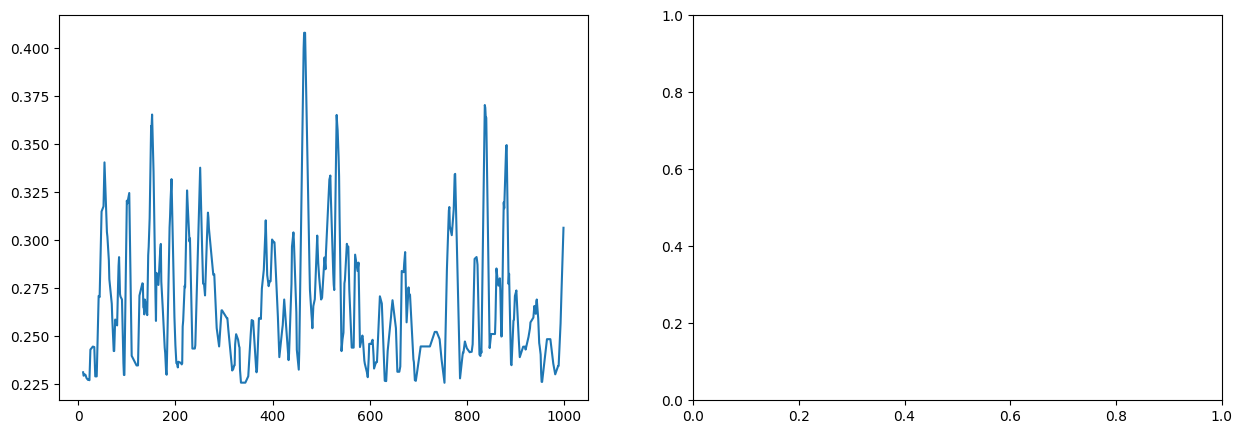

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MH._KL_plot(axs[0])

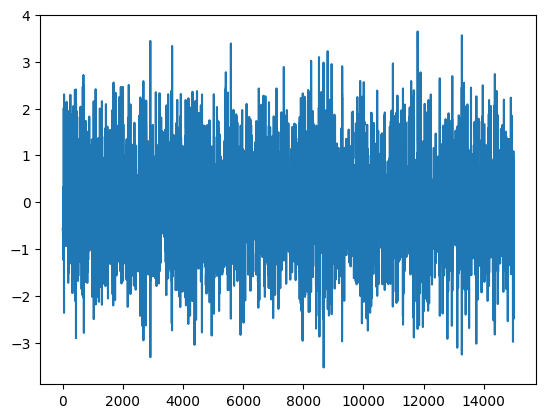

In [16]:
MH._trace_plot()

In [30]:
cumsum_vec = np.cumsum(np.insert(MH.samples, 0, 0)) 
window_width = 100
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
print(ma_vec.shape)

(14901,)


In [33]:
MH.samples.__len__()

15000

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20]),
 array([0.00221519, 0.00889229, 0.00926426, 0.01330447, 0.01756509,
        0.01979456, 0.02275612, 0.0230877 , 0.0201591 , 0.02835713,
        0.03788247, 0.05086517, 0.06455982, 0.08309   , 0.11363754,
        0.1573724 , 0.22305977, 0.32598737, 0.4766404 , 0.6938037 ,
        1.        , 0.6938037 , 0.4766404 , 0.32598737, 0.22305977,
        0.1573724 , 0.11363754, 0.08309   , 0.06455982, 0.05086517,
        0.03788247, 0.02835713, 0.0201591 , 0.0230877 , 0.02275612,
        0.01979456, 0.01756509, 0.01330447, 0.00926426, 0.00889229,
        0.00221519], dtype=float32),
 <matplotlib.lines.Line2D at 0x1ab5b457c40>)

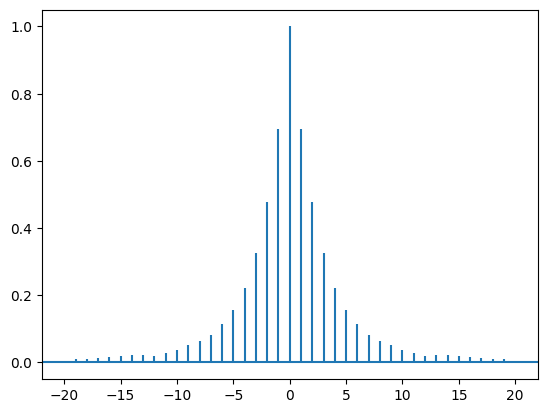

In [11]:
plt.acorr(MH.samples, maxlags=20)

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20]),
 array([0.42904493, 0.44748226, 0.46648836, 0.4870512 , 0.5086917 ,
        0.53270525, 0.5575662 , 0.5832066 , 0.6079841 , 0.6341606 ,
        0.6612056 , 0.6903728 , 0.72140056, 0.7529821 , 0.78497756,
        0.8172255 , 0.8516216 , 0.8863572 , 0.9218288 , 0.96024305,
        1.        , 0.96024305, 0.9218288 , 0.8863572 , 0.8516216 ,
        0.8172255 , 0.78497756, 0.7529821 , 0.72140056, 0.6903728 ,
        0.6612056 , 0.6341606 , 0.6079841 , 0.5832066 , 0.5575662 ,
        0.53270525, 0.5086917 , 0.4870512 , 0.46648836, 0.44748226,
        0.42904493], dtype=float32),
 <matplotlib.lines.Line2D at 0x1ab5a327e80>)

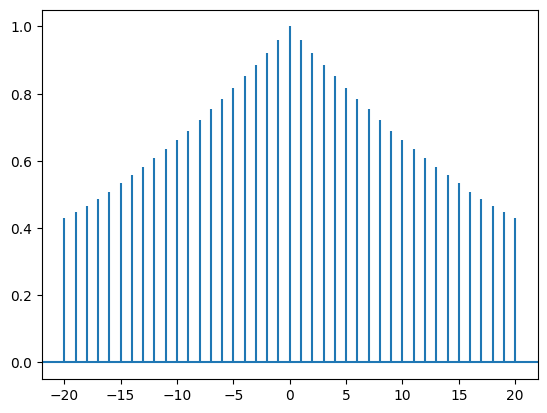

In [8]:
plt.acorr(MH.samples, maxlags=20)

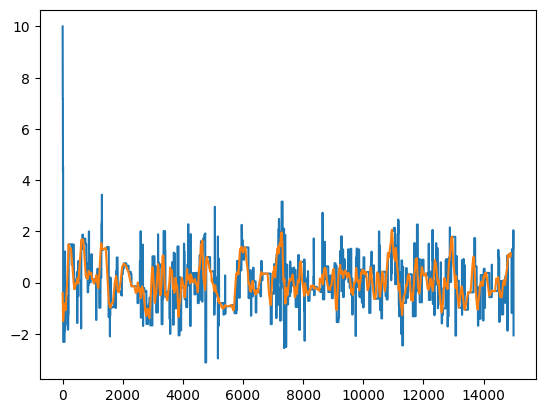

In [12]:
plt.plot(MH.samples)
plt.plot(ma_vec)

In [18]:
KL= - Normal(0, 1).log_prob(torch.tensor(MH.samples))
KL_cumsum = np.cumsum(KL)
mean_KL = (KL_cumsum[window_width:] - KL_cumsum[:-window_width]) / window_width

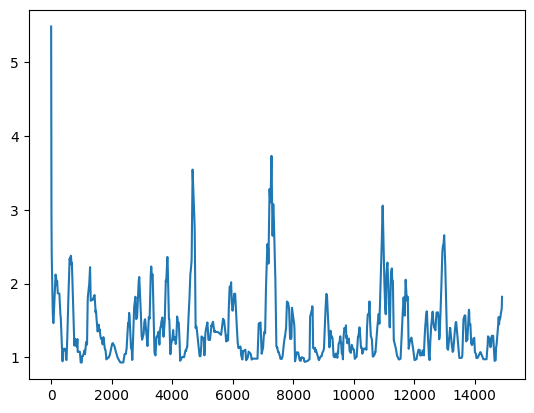

In [19]:
plt.plot(mean_KL)

In [148]:
MH._acceptance_prob(torch.tensor(1))

0.9455132167348842

(array([0.064537  , 0.        , 0.        , 0.        , 0.38722181,
        0.12907394, 0.32268484, 0.        , 0.32268484, 0.12907394,
        0.38722181, 0.8389806 , 0.38722181, 1.0325915 , 0.12907394,
        1.16166544, 0.8389806 , 0.90351757, 1.8715721 , 0.90351757,
        1.871573  , 0.64536938, 1.16166488, 0.774444  , 1.871573  ,
        1.8715712 , 1.61342345, 0.96805407, 2.58148248, 0.90351713,
        0.77444326, 1.22620418, 0.83898019, 0.5162955 , 0.19361081,
        0.90351713, 0.32268531, 1.67796039, 0.38722163, 0.12907412,
        0.        , 0.45175857, 0.        , 0.06453694, 0.        ,
        0.32268469, 0.12907437, 0.        , 0.        , 0.25814775]),
 array([-0.35376367, -0.32277369, -0.29178369, -0.26079369, -0.22980371,
        -0.19881372, -0.16782373, -0.13683374, -0.10584375, -0.07485376,
        -0.04386377, -0.01287378,  0.01811621,  0.0491062 ,  0.08009619,
         0.11108617,  0.14207616,  0.17306615,  0.20405614,  0.23504613,
         0.26603612,  0.29

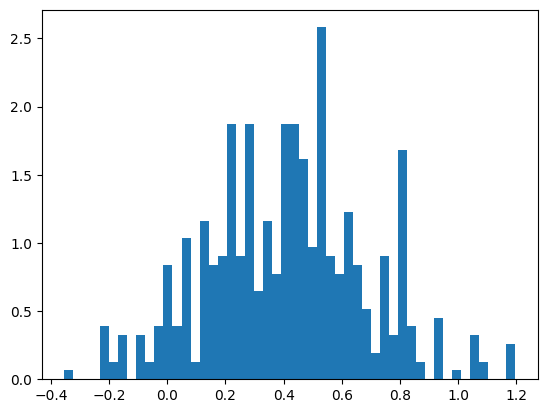

In [93]:
plt.hist(MH.samples, density=True, bins=50)

burnin

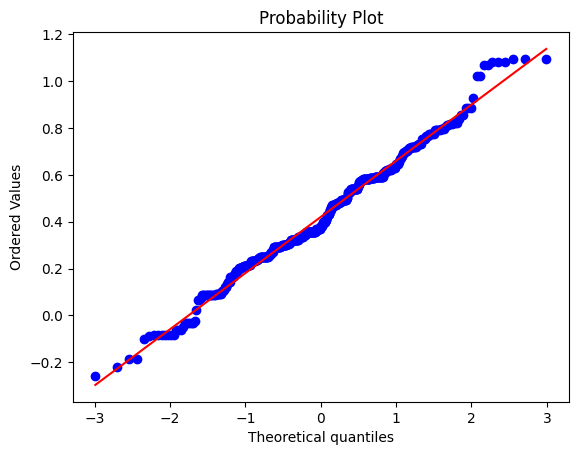

In [91]:
stats.probplot(MH.samples, dist="norm", plot=plt);

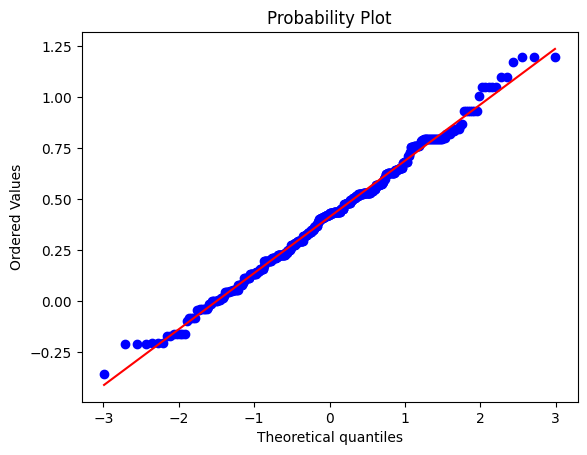

In [94]:
stats.probplot(MH.samples, dist="norm", plot=plt);

In [50]:
MH = MetropolisHastings(torch.distributions.exponential.Exponential(1), IndependentGaussianProposal(0, 1))
MH.sample(1000, torch.tensor(1.))

ValueError: Expected value argument (Tensor of shape ()) to be within the support (GreaterThanEq(lower_bound=0.0)) of the distribution Exponential(rate: 1.0), but found invalid values:
-0.6608418226242065